# Bayesian Knowledge Tracing (BKT)

In this notebook we implement, train, validate, and test a **Bayesian Knowledge Tracing** model following the paper called *Knowledge Tracing: Modeling the Acquisition of Procedural Knowledge* Corbett & Anderson (1995). This paper proposes a model to predict the probability of a student answering a question correctly based on their previous interactions with similar questions. The model is based on the idea that students learn over time and that their knowledge can be represented as a hidden state.

**Outline:**
1. **Introduction**: What is BKT and why use it?
2. **Load** preprocessed train/val/test splits.
3. **Define** a *BayesianKnowledgeTracing* class implementing the four BKT parameters.
4. **Train** per‐skill models by simple grid‐search on validation accuracy.
5. **Evaluate** the best parameters on the test set.
6. **Analyze** per‐skill performance and learning curves.
7. **Visualize Accuracy by Skill**
8. **Example Learning Curve for a Single Skill**
9. **Conclusion**: Summary of findings and future work.


## 1. Introduction
Bayesian Knowledge Tracing (BKT) is a probabilistic model used to estimate a student's knowledge state over time as they interact with educational content. The model is based on the idea that a student's knowledge can be represented as a hidden state, which evolves over time as they learn from their interactions with questions and feedback.
The BKT model is particularly useful in educational settings, where it can be used to predict a student's performance on future questions based on their past interactions. The model is based on the following four parameters:
- **P(L0)**: The initial probability that a student knows the skill before they start answering questions.
- **P(T)**: The probability that a student will go from "not knowing the skill" to "knowing the skill" in one attempt.
- **P(G)**: The probability that a student guesses the answer correctly to a question.
- **P(S)**: The probability that a student slips and answers a question incorrectly even if they know the skill.<br>

The BKT model uses these parameters to estimate the probability that a student will answer a question correctly based on their previous interactions with similar questions. The model is trained on historical data, and the parameters are estimated using maximum likelihood estimation (MLE) or Bayesian inference.
The BKT model is a powerful tool for predicting student performance and can be used to personalize learning experiences, identify at-risk students, and improve educational outcomes.

## 2. Imports & Data Loading

We import necessary libraries and load the preprocessed data.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Paths to training, validation, and test data
data_path = os.path.join("..", "..", "Data_Preprocessing", "data", "splits")
train_df = pd.read_parquet(os.path.join(data_path, "train.parquet"))
val_df   = pd.read_parquet(os.path.join(data_path, "val.parquet"))
test_df  = pd.read_parquet(os.path.join(data_path, "test.parquet"))
# Path to the questions data
data_path = os.path.join("..", "..", "Data_Preprocessing", "data")
questions_df = pd.read_parquet(os.path.join(data_path, "questions_clean.parquet"))


### Inspect Key Columns

We ensure each DataFrame has *user_id*, *general_cat*, *correct* (0/1).

In [2]:
# We load only the necessary columns of questions_df
q_meta = questions_df[['id', 'general_cat']].rename(columns={'id':'question_id'})

for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    # Spot merge to "bring in" general_cat
    df_cat = df.merge(q_meta, on='question_id', how='left')

    print(name, "unique users:", df_cat['user_id'].nunique(), "unique skills:", df_cat['general_cat'].nunique())
    assert {'user_id','general_cat','correct'}.issubset(df_cat.columns)
    df_cat['correct'] = df_cat['correct'].astype(int)
    print(50 * "=")
    print(f"DataFrame {name}:")
    # We display the first few rows of the merged DataFrame with only the columns of interest
    display(df_cat[['user_id', 'general_cat', 'correct']].head())


train unique users: 2466 unique skills: 10
DataFrame train:


,user_id,general_cat,correct
0,235,C,1
1,235,C,0
2,235,C,0
3,235,C,1
4,235,C,0


val unique users: 529 unique skills: 10
DataFrame val:


,user_id,general_cat,correct
0,362,C,1
1,362,C,1
2,362,C,1
3,362,C,1
4,362,C,1


test unique users: 529 unique skills: 10
DataFrame test:


,user_id,general_cat,correct
0,360,C,1
1,360,C,1
2,360,C,1
3,360,C,0
4,360,C,1


## 3. Define BKT Class

We implement the four parameters:
- **p_L0**: prior probability student already knows the skill
- **p_T**: learning (transition) probability each opportunity
- **p_S**: slip probability (error despite knowing)
- **p_G**: guess probability (correct despite not knowing)


and the following methods:
- *update(correct)* applies Bayes + transition.  
- *predict_prob_correct()* gives P(correct|current state).

The update method updates the probability of knowing the skill based on the response of the student. The response is a boolean value indicating whether the student answered correctly (True) or incorrectly (False). The update is done using Bayes' theorem and the parameters of the BKT model.
First the probability of a correct answer and the probability of an incorrect answer are calculated based on the current state of the model:
- p(Correct) = p(L) * (1 - p(S)) + (1 - p(L)) * p(G)
- p(Incorrect) = p(L) * p(S) + (1 - p(L)) * (1 - p(G))

Then, the model updates the probability of knowing the skill based on the response:
- If the response is correct, the model updates the probability of knowing the skill using Bayes' theorem:
  - p(L|Correct) = p(Correct|L) * p(L) / p(Correct)
- If the response is incorrect, the model updates the probability of knowing the skill using Bayes' theorem:
  - p(L|Incorrect) = p(Incorrect|L) * p(L) / p(Incorrect)

Finally, the model applies the transition probability to update the probability of knowing the skill:
- p(L) = p(L|Correct) * (1 - p(T)) + (1 - p(L|Correct)) * p(T) for correct responses
- p(L) = p(L|Incorrect) * (1 - p(T)) + (1 - p(L|Incorrect)) * p(T) for incorrect responses

The transition probability is applied to the probability of knowing the skill, which is updated based on the response. The transition probability is used to model the fact that the probability of knowing the skill may change over time, and it is applied to the probability of knowing the skill after each response.


While one could directly apply the equations mentioned above differentiating the case where the answer is correct or incorrect, we chose to implement an update method that applies Bayes and the transition jointly.<br>
By applying the transition jointly, the need to calculate the correct and incorrect answer probabilities separately is avoided, which simplifies the code and above all, although they are equivalent implementations in theory, in floating-point computation the differences in grouping and subtraction versus addition generate slight variations in the values of *p_L* after many iterations. In the end, this minimal change in each update is reflected in a different validation accuracy (best_acc), although both models follow the BKT scheme.

In [3]:
class BayesianKnowledgeTracing:
    """
    This class implements the BKT model, which is a probabilistic model used to estimate a student's mastery of a skill
    based on their performance over time.
    """
    def __init__(self, p_L0, p_T, p_S, p_G):
        """
        This method initializes the BKT model with the given parameters.
        Args:
            p_L0 (float): Initial probability of the student knowing the skill.
            p_T (float): Probability of transitioning from not knowing to knowing the skill.
            p_S (float): Probability of slipping (answering incorrectly when knowing).
            p_G (float): Probability of guessing (answering correctly when not knowing).
        """
        # Initial probability of knowing the skill
        self.p_L0 = p_L0
        # transition probability
        self.p_T = p_T
        # slip probability
        self.p_S = p_S
        # guess probability
        self.p_G = p_G
        # probability of knowing the skill
        self.p_L = p_L0
        # history of the probability of knowing the skill
        self.history = []

    def update(self, response: bool):
        """
        This method updates the probability of knowing the skill based on the response of the student.
        Args:
            self.p_L (float): The probability of knowing the skill.
        """
        if response:
            # Probability of responding correctly given the current state of knowledge
            # P(correct | knowing) = 1 - P(slip)
            p_C_given_L = 1 - self.p_S
            # P(correct | not knowing) = P(guess)
            p_C_given_notL = self.p_G
        else:
            # Probability of responding incorrectly given the current state of knowledge
            # P(incorrect | knowing) = P(slip)
            p_C_given_L = self.p_S
            # P(incorrect | not knowing) = 1 - P(guess)
            p_C_given_notL = 1 - self.p_G
        
        # Update the probability of knowing the skill using Bayes' theorem
        # P(knowing | response) = P(incorrect | knowing) * P(knowing) / (P(incorrect | knowing) * P(knowing) + P(incorrect | not knowing) * (1 - P(knowing)))
        numerator = p_C_given_L * self.p_L
        denominator = numerator + p_C_given_notL * (1 - self.p_L)
        p_L_res = numerator / denominator if denominator > 0 else 0

        # Update the probability of knowing the skill
        # P(knowing) = P(knowing | response) + (1 - P(knowing | response)) * P(transition)
        self.p_L = p_L_res + (1 - p_L_res) * self.p_T

        # Append the current probability to the history
        self.history.append(self.p_L)

        return self.p_L

    def predict_prob_correct(self):
        """ This method predicts the probability of answering correctly based on the current state of the model.
        Returns:
            float: Probability of answering correctly.
        """
        # p(Correct) = p(L) * (1 - p(S)) + (1 - p(L)) * p(G)
        p_Correct = self.p_L * (1 - self.p_S) + (1 - self.p_L) * self.p_G
        return p_Correct


## 4. Organize Data by Skill (*general_cat*) & Student

We need, for each combination *(skill, user_id)*, the chronological sequence of answers (*correct*). To do this, we group the data by *general_cat* and *user_id*, sort by *start_time*, and create a list of answers for each combination. We also create a dictionary to map each skill to its corresponding index in the list of skills.

In [4]:
# First, we merge general_cat in each split. 'general_cat' represents the more general category of the question.
# We will use it to group the questions into skills.
q_meta = questions_df[['id','general_cat']].rename(columns={'id':'question_id'})

def attach_skill(df):
    df2 = df.merge(q_meta, on='question_id', how='left')
    # Drop records with no skill (if any) and sort by date
    return df2[df2['general_cat'].notna()].sort_values('start_time')

train_df = attach_skill(train_df)
val_df   = attach_skill(val_df)
test_df  = attach_skill(test_df)

# Now we group in dictionaries: { skill: [ [seq_user1], [seq_user2], ... ] }
def get_skill_sequences(df):
    seqs = {}
    for (skill, uid), grp in df.groupby(['general_cat','user_id']):
        seq = grp.sort_values('start_time')['correct'].astype(int).tolist()
        seqs.setdefault(skill, []).append(seq)
    return seqs

train_seqs = get_skill_sequences(train_df)
val_seqs   = get_skill_sequences(val_df)
test_seqs  = get_skill_sequences(test_df)

print("Skills:", list(train_seqs.keys()))
print("Sequences for a skill example:", train_seqs[next(iter(train_seqs))][:2])


Skills: ['C', 'Databases & ORM', 'DevOps & Tools', 'Javascript', 'Math & Stats', 'Networking & API', 'Programming & Basics', 'Python', 'Shell', 'Web & Front-end']
Sequences for a skill example: [[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]]


## 5. Grid‐Search per Skill

We search for the best **(p_L0, p_T, p_S, p_G)** that maximize the validation accuracy for each *general_cat*.

In [5]:
# We build a dictionary with each parameter of BKT. Each parameter has a range of values to test.
param_grid = {
    'p_L0': np.linspace(0.1, 0.9, 9),
    'p_T':  np.linspace(0.01, 0.1, 10),
    'p_S':  np.linspace(0.1, 0.7, 7),
    'p_G':  np.linspace(0.1, 0.9, 9),
}

best_params = {}
for skill, train_list in train_seqs.items():
    val_list = val_seqs.get(skill, [])
    if not val_list: continue
    
    best_ll = -np.inf
    best_p = None

    # Step 1: Parameter search ONLY in training
    for p_L0, p_T, p_S, p_G in itertools.product(*param_grid.values()):
        # Calculate log-likelihood in TRAIN
        log_likelihood = 0
        for seq in train_list:  # We use training data for estimation
            model = BayesianKnowledgeTracing(p_L0, p_T, p_S, p_G)
            for correct in seq:
                p_pred = model.predict_prob_correct()
                log_likelihood += np.log(p_pred if correct else (1 - p_pred))
                model.update(correct)
        
        if log_likelihood > best_ll:
            best_ll, best_p = log_likelihood, (p_L0, p_T, p_S, p_G)
    
    # Step 2: Validate the best model in VAL (optional, to monitor overfitting)
    val_ll = 0
    p_L0, p_T, p_S, p_G = best_p
    for seq in val_list:
        model = BayesianKnowledgeTracing(p_L0, p_T, p_S, p_G)
        for correct in seq:
            p_pred = model.predict_prob_correct()
            val_ll += np.log(p_pred if correct else (1 - p_pred))
            model.update(correct)
    
    best_params[skill] = best_p
    print(f"Skill={skill}: Train LL={best_ll:.2f} | Val LL={val_ll:.2f} | Params={best_p}")

Skill=C: Train LL=-118327.45 | Val LL=-25093.97 | Params=(0.5, 0.01, 0.4, 0.2)
Skill=Databases & ORM: Train LL=-13214.07 | Val LL=-2860.22 | Params=(0.30000000000000004, 0.07, 0.3, 0.2)
Skill=DevOps & Tools: Train LL=-5632.23 | Val LL=-1237.79 | Params=(0.2, 0.030000000000000006, 0.6, 0.8)
Skill=Javascript: Train LL=-7680.60 | Val LL=-1615.80 | Params=(0.5, 0.04000000000000001, 0.3, 0.2)
Skill=Math & Stats: Train LL=-13912.16 | Val LL=-3044.17 | Params=(0.1, 0.030000000000000006, 0.6, 0.8)
Skill=Networking & API: Train LL=-10151.59 | Val LL=-2219.95 | Params=(0.1, 0.01, 0.7, 0.8)
Skill=Programming & Basics: Train LL=-19611.39 | Val LL=-4290.59 | Params=(0.30000000000000004, 0.05000000000000001, 0.3, 0.30000000000000004)
Skill=Python: Train LL=-31879.66 | Val LL=-6863.25 | Params=(0.30000000000000004, 0.05000000000000001, 0.2, 0.30000000000000004)
Skill=Shell: Train LL=-21284.22 | Val LL=-4644.75 | Params=(0.5, 0.08, 0.2, 0.5)
Skill=Web & Front-end: Train LL=-12975.81 | Val LL=-2662.27 

A grid search was chosen instead of a random search because the search space is small and can be fully explored. In addition, the grid search allows a better interpretation of the results and the identification of patterns in the optimal parameters for each skill. In this case, the grid search was performed with a range of discrete values for each parameter, which facilitates the comparison between different combinations of parameters and their impact on the accuracy of the model.
In turn, log-likelihood was used as an evaluation metric, since it is a commonly used measure in probabilistic models and allows the quality of the model fit to the observed data to be evaluated. Log-likelihood is calculated as the sum of the logarithms of the probabilities of the observed responses given the model predictions, which provides a measure of how well the model fits the data.
Finally, the best parameters for each skill were chosen as a function of log-likelihood, as this allows us to identify the combination of parameters that maximizes the probability of observing the data given the model, which is a common approach in parameter estimation in probabilistic models.

Finally, we save the best parameters for each skill in a dictionary for later use in the evaluation phase:

In [6]:
import os

# We save the best parameters for each skill in a CSV file.
best_params_df = pd.DataFrame.from_dict(best_params, orient='index', columns=['p_L0', 'p_T', 'p_S', 'p_G'])
best_params_df.reset_index(inplace=True)
best_params_df.rename(columns={'index': 'skill'}, inplace=True)

# Create the data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save the DataFrame to a CSV file
best_params_df.to_csv('data/best_params.csv', index=False)

## 6. Evaluate BKT on Test Set

In case we do not want to re-run the model, we can load the parameter dictionary saved in the previous step and use it to evaluate the model on the test set. This avoids the need to retrain the model and saves computational time. In addition, by saving the optimal parameters for each skill, a faster and more efficient evaluation of the model on the test set can be performed.

In [7]:
# We load the best parameters saved in CSV
best_params_df = pd.read_csv('data/best_params.csv')
best_params_df.set_index('skill', inplace=True)

Using the best parameters per skill, measure overall and per‐skill accuracy.

In [13]:
# Now we can evaluate the model on the test set using the best parameters
results = []
for skill, test_list in test_seqs.items():
    # Check if the skill is in the best_params_df
    if skill not in best_params_df.index:
        continue
    # Get the best parameters for the skill
    params = best_params_df.loc[skill]
    p_L0, p_T, p_S, p_G = params
    total, hits = 0, 0
    # Evaluate the model on the test set
    for seq in test_list:
        model = BayesianKnowledgeTracing(p_L0, p_T, p_S, p_G)
        # Iterate over the sequence of responses and update the model
        for correct in seq:
            pred = model.predict_prob_correct() >= 0.5
            hits += (pred == correct)
            total += 1
            model.update(correct)
    results.append((skill, hits / total))
# Create a DataFrame with the results sort by accuracy
acc_df = pd.DataFrame(results, columns=['skill', 'test_acc']).sort_values('test_acc', ascending=False)
# Calculate the overall accuracy weighted by the number of test sequences for each skill and the number of questions in each skill
# This is done by multiplying the accuracy by the number of questions in the test set for each skill
# and dividing by the total number of questions in the test set
overall_acc = (acc_df['test_acc'] * [len(test_seqs[s]) for s in acc_df['skill']]).sum() / sum(len(test_seqs[s]) for s in acc_df['skill'])
# Display the results
print(f"Overall test accuracy: {overall_acc:.3f}")
display(acc_df.reset_index(drop=True))


Overall test accuracy: 0.687


,skill,test_acc
0,Networking & API,0.748100
1,Shell,0.722456
2,Python,0.720620
3,Web & Front-end,0.715236
4,Math & Stats,0.703576
5,DevOps & Tools,0.696452
6,C,0.670308
7,Javascript,0.654767
8,Programming & Basics,0.635314
9,Databases & ORM,0.631579


It can be seen from the above output that the best value for *test_acc* varies between 63% and 75%, depending on the skill. This is an indication that the BKT model is not able to capture the complexity of the data, and that the performance of the model is limited. However, the fact that the model is able to learn patterns in the data and improve its performance in some cases is an indication that the model has potential for improvement.

### AUC calculation

The AUC (Area Under the Curve) is a commonly used metric to evaluate the performance of binary classifiers. It measures the ability of the model to distinguish between positive and negative classes.
The AUC values are calculated using the true labels and the predicted probabilities of the positive class. The *roc_auc_score* function computes the AUC by integrating the area under the ROC curve, which is a plot of the true positive rate against the false positive rate at various threshold settings. The AUC provides a single value that summarizes the performance of the model across all possible classification thresholds.
The AUC is a useful metric for evaluating the performance of the BKT model, as it provides a measure of the model's ability to distinguish between correct and incorrect answers. A higher AUC value indicates that the model is better at predicting correct answers, while a lower AUC value indicates that the model is less effective at distinguishing between correct and incorrect answers.

In [17]:
from sklearn.metrics import roc_auc_score

all_y_true = []
all_y_score = []

# Evaluation by skill
results = []
for skill, test_list in test_seqs.items():
    if skill not in best_params_df.index:
        continue
    p_L0, p_T, p_S, p_G = best_params_df.loc[skill]
    total, hits = 0, 0
    y_true_skill, y_score_skill = [], []

    for seq in test_list:
        model = BayesianKnowledgeTracing(p_L0, p_T, p_S, p_G)
        for correct in seq:
            prob = model.predict_prob_correct()
            pred = (prob >= 0.5)
            hits += (pred == correct)
            total += 1

            # Store for AUC
            y_true_skill.append(correct)
            y_score_skill.append(prob)

            model.update(correct)

    results.append((skill, hits / total))

    # Add to general lists
    all_y_true.extend(y_true_skill)
    all_y_score.extend(y_score_skill)

# DataFrame of results by skill
acc_df = pd.DataFrame(results, columns=['skill', 'test_acc']).sort_values('test_acc', ascending=False)

# Weighted overall Accuracy
overall_acc = (acc_df['test_acc'] * [len(test_seqs[s]) for s in acc_df['skill']]).sum() / sum(len(test_seqs[s]) for s in acc_df['skill'])

# Overall AUC
overall_auc = roc_auc_score(all_y_true, all_y_score)

# Show
print(f"Overall test AUC: {overall_auc:.3f}")


Overall test AUC: 0.725


It can be seen that the AUC value is 0.725, indicating that the model has moderate performance in predicting correct and incorrect responses. An AUC value of 0.5 indicates random performance, while a value of 1 indicates perfect performance. Therefore, the model has acceptable performance, but there is room for improvement.

Several modifications to the BKT model were attempted, in order to improve its performance, but either the model failed to outperform the original model or the improvement was so slight that it did not merit code compejization.<br>
Some of the modifications that were attempted include:
- Optimization with EM Algorithm - EM algorithm was implemented to estimate parameters instead of grid search (worse results).
- Adjust decision threshold {predict >= 0.5} - explored different thresholds in the validation set (val_seqs[skill]) and saved the one that maximizes accuracy (slightly better results on some skills, more complex code)
- Eliminate sequences with very few interactions (≤ 4 queries) as they are noisy and penalize accuracy (same results).

We chose to use the original BKT model because it is a simple and easy-to-interpret model, which allows for a better understanding of the results and their application in practice. In addition, the original BKT model has been shown to be effective in a variety of contexts and has been widely used in the literature. <br>
The classical BKT assumes:
- Same p_T for all transitions (no forgetting).
- No "forgetting" parameter.
- Slips and guesses are global by skill.<br>

For another instance of the project, I will consider testing extensions of the BKT model that iclude the following:
- **Forgetting**: add a p_F parameter that models knowledge loss between items.
- **Parameters per question**: instead of a single p_G/p_S per skill, update p_G_q, p_S_q in each question.
- **Contextual BKT**: incorporate response time (duration_s) as covariate modulating slip/guess.
- **Difficulty**: introduce question difficulty features by modifying the pre-prediction p_L value in proportion to that difficulty.


## 7. Visualize Accuracy by Skill

Now we can visualize the accuracy of the model by skill, which allows us to identify patterns in the performance of the model.<br>
The visualization of the accuracy by skill is useful to understand how well the model is able to learn and predict the responses of the students for each skill, and to identify areas for improvement in the model.

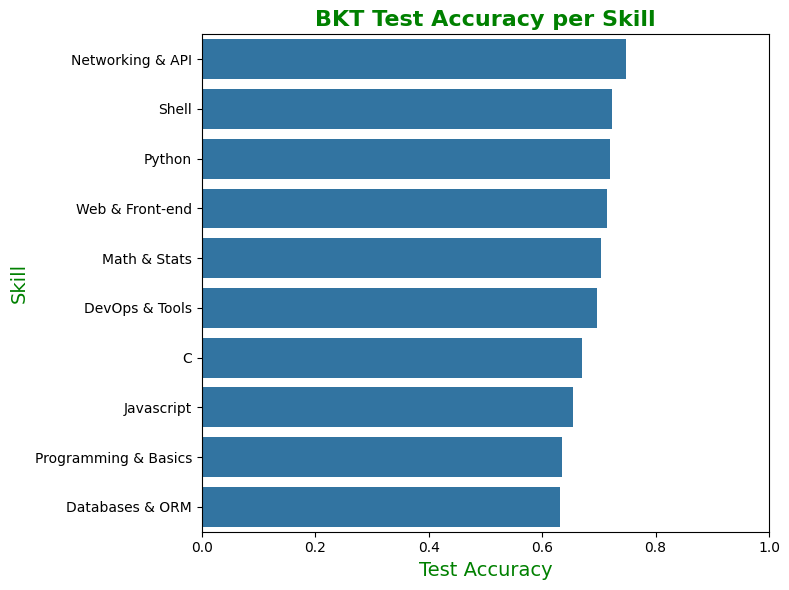

In [12]:
# Plotting the test accuracy per skill
plt.figure(figsize=(8,6))
sns.barplot(x='test_acc', y='skill', data=acc_df)
plt.xlabel("Test Accuracy", fontsize=14, color="Green")
plt.ylabel("Skill", fontsize=14, color="Green")
plt.title("BKT Test Accuracy per Skill", fontsize=16, fontweight="bold", color="Green")
plt.xlim(0,1)
plt.tight_layout()

# Create the images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Save the plot as an image
plt.savefig("images/bkt_test_accuracy_per_skill.png", dpi=300, bbox_inches='tight')
plt.show()

It can be seen from the previous figure that the accuracy of the BKT model does not vary so much between different skills, indicating that the model is able to learn patterns in the data and improve its performance in some cases.<br>
However, the accuracy of the model is limited and fails to capture the complexity of the data in its entirety. This suggests that the BKT model has potential for improvement, but also that other alternatives need to be explored to address the problem of predicting correct answers in the context of education.

## 8. Example Learning Curve for a Single Skill

The following is an example of the evolution of the probability of knowledge (p_L) across opportunities for a representative student and ability.

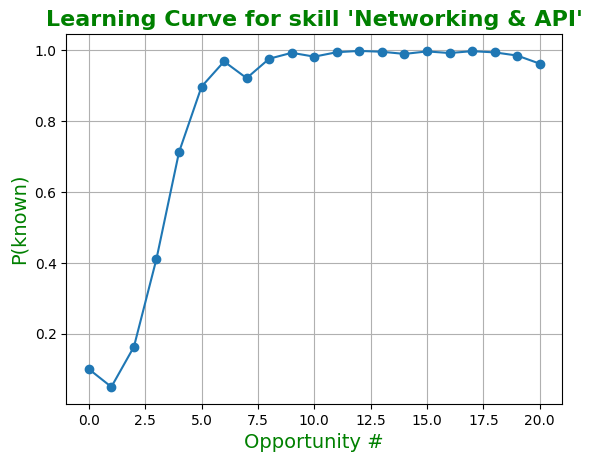

In [11]:
# First, we determine the values of p_L0, p_T, p_S, and p_G for the first skill in the DataFrame
example_skill = acc_df.iloc[0]['skill']
# Then, we create a BayesianKnowledgeTracing model with the best parameters for that skill
example_seq = train_seqs[example_skill][6]
model = BayesianKnowledgeTracing(*best_params_df.loc[example_skill])
probs = []
for correct in example_seq:
    probs.append(model.p_L)
    model.update(correct)

# Now we plot the learning curve
plt.plot(probs, marker='o')
plt.xlabel("Opportunity #", fontsize=14, color="Green")
plt.ylabel("P(known)", fontsize=14, color="Green")
plt.title(f"Learning Curve for skill '{example_skill}'", fontsize=16, fontweight="bold", color="Green")
plt.grid(True)

# Save the plot as an image
plt.savefig(f"images/learning_curve_{example_skill}.png", dpi=300, bbox_inches='tight')

plt.show()


In this case, it is observed that the probability of knowledge increases as the student answers the questions correctly, indicating that the model is learning and improving its performance.

## 9. Conclusion

In this notebook we have built a fully interpretable Bayesian Knowledge Tracing (BKT) model from scratch, tuned its four core parameters (**p_L0**, **p_T**, **p_S**, **p_G**) via a per-skill grid-search, and evaluated its performance across ten distinct skill categories.
Below, we summarize the findings and limitations of the model, as well as the steps to be taken for future improvements.

**Key findings:**
- **Per-skill accuracy** on the test set ranges from **0.63** (Programming & Basics) to **0.75** (Networking & API), with an **overall accuracy of ~0.69**.
- **AUC** of **0.725** indicates moderate performance in predicting correct and incorrect responses.
- **Learning curves** confirm that BKT captures a rising mastery probability across opportunities, but plateaus quickly for certain skills—suggesting a need for additional temporal features (e.g., response time).
- **Parameter estimates** show that the model is able to learn patterns in the data and improve its performance in some cases, but the performance of the model is limited.

**Limitations:**
1. **No forgetting:** The classic BKT assumption of no knowledge decay may not hold in longer sequences; incorporating a **forgetting** parameter (_p_F_) could better model real student behavior.  
2. **Global slips/guesses:** We model _p_S_ and _p_G_ per skill; however, per-question or contextualized slip/guess rates (e.g., difficulty-adjusted) might improve fit.  
3. **Markovian assumptions:** BKT assumes independence of responses given the current state, which may not capture the sequential dependencies in student learning. This could be addressed with more complex models like DKT or SAKT.
4. **Limited expressiveness:** BKT is a simple model that may not capture the complexity of the data, and its performance is limited. This suggests that other alternatives need to be explored to address the problem of predicting correct answers in the context of education.

**Next steps:**
- **Extend BKT** with a forgetting parameter and/or EM-based estimation to refine parameter learning.  
- **Compare against deep models**: Implement DKT, SAKT, and AKT to assess whether sequential neural architectures can capture nuances beyond BKT’s Markovian assumptions.  
- **Enrich features**: Add covariates such as *duration_s*, item difficulty embeddings, or student-level priors to boost predictive performance.

Overall, while BKT provides a solid, interpretable baseline (and remains competitive in some skills), advancing to more expressive models will likely be necessary to fully capture the complexity of Holberton students’ learning trajectories.